# Predicting NHL Game Outcomes

## Sandbox Notebook

Working notebook 
When components (e.g. scraping functions) are working, move them to eventual production home

In [2]:
# Standard Packages
import pandas as pd
# from pandas.testing import assert_frame_equal
import numpy as np
import requests
import re
import time
import os
import warnings

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Modeling Packages
## Modeling Prep
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, \
GridSearchCV, RandomizedSearchCV

## SKLearn Data Prep Modules
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, \
PolynomialFeatures, PowerTransformer, Normalizer, MaxAbsScaler

from sklearn.impute import SimpleImputer

## SKLearn Classification Models
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor, GradientBoostingClassifier

## SKLearn Pipeline Setup
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## SKLearn Model Optimization
from sklearn.feature_selection import RFE, f_regression

## Boosting
# from xgboost import XGBClassifier

## SKLearn Metrics
### Classification Scoring/Evaluation
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, \
ConfusionMatrixDisplay, log_loss, confusion_matrix, RocCurveDisplay, make_scorer, roc_auc_score

## TensorFlow
#for the Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from keras.constraints import maxnorm

In [5]:
# Notebook Config
from pprintpp import pprint as pp
%reload_ext pprintpp
from tqdm import tqdm
from io import StringIO

## Suppress Python Warnings (Future, Deprecation)
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Suppress Pandas Warnings (SettingWithCopy)
pd.options.mode.chained_assignment = None

## Pandas Display Config
pd.options.display.max_columns = 80
# pd.options.display.width = None

## Display SKLearn estimators as diagrams
from sklearn import set_config
set_config(display= 'diagram')

## Progress bars
from tqdm.notebook import tqdm
pbar = tqdm(..., display=False) # disable by default
display(pbar.container) # display progress bar in desired cell

##  Modeling

In [6]:
# load modeling df
modeling_df = pd.read_csv('modeling_data.csv')
modeling_df

,season_id,home_team,away_team,Home_Team_Won,home_pts_pct,away_pts_pct,home_TOI,home_FF/60,home_FA/60,home_FF%,home_GF/60,home_GA/60,home_GF%,home_xGF/60,home_xGA/60,home_xGF%,home_HDCF/60,home_HDCA/60,home_HDCF%,home_HDSH%,home_HDSV%,home_SH%,home_SV%,home_PDO,home_TOI_pp,home_GF/60_pp,home_xGF/60_pp,home_TOI_pk,home_GA/60_pk,home_xGA/60_pk,away_TOI,away_FF/60,away_FA/60,away_FF%,away_GF/60,away_GA/60,away_GF%,away_xGF/60,away_xGA/60,away_xGF%,away_HDCF/60,away_HDCA/60,away_HDCF%,away_HDSH%,away_HDSV%,away_SH%,away_SV%,away_PDO,away_TOI_pp,away_GF/60_pp,away_xGF/60_pp,away_TOI_pk,away_GA/60_pk,away_xGA/60_pk
0,20192020,TOR,OTT,1,1.000000,0.000000,44.133333,59.15,43.75,57.48,5.16,4.18,55.27,3.44,2.22,60.73,15.74,8.32,65.42,55.99,24.79,11.94,85.60,0.975,8.166667,7.35,7.47,6.000000,0.00,2.77,44.133333,43.75,59.15,42.52,4.18,5.16,44.73,2.22,3.44,39.27,8.32,15.74,34.58,75.21,44.01,14.40,88.06,1.025,6.000000,0.00,2.77,8.166667,7.35,7.47
1,20192020,STL,WSH,0,0.500000,1.000000,50.866667,27.17,39.14,40.97,1.11,1.20,48.19,1.35,2.26,37.48,5.59,6.14,47.66,19.64,100.00,5.56,95.79,1.014,3.250000,18.46,6.44,5.883333,10.20,7.62,50.866667,39.14,27.17,59.03,1.20,1.11,51.81,2.26,1.35,62.52,6.14,5.59,52.34,0.00,80.36,4.21,94.44,0.986,5.883333,10.20,7.62,3.250000,18.46,6.44
2,20192020,EDM,VAN,1,1.000000,0.000000,47.066667,30.38,48.03,38.75,3.58,2.64,57.61,1.71,1.99,46.24,6.04,9.11,39.87,39.29,65.85,14.87,91.33,1.062,4.000000,0.00,4.60,8.000000,0.00,9.09,47.066667,48.03,30.38,61.25,2.64,3.58,42.39,1.99,1.71,53.76,9.11,6.04,60.13,34.15,60.71,8.67,85.13,0.938,8.000000,0.00,9.09,4.000000,0.00,4.60
3,20192020,VGK,S.J,1,1.000000,0.000000,45.666667,51.94,30.07,63.34,2.60,1.33,66.09,3.84,1.40,73.28,16.02,5.27,75.25,12.06,100.00,8.07,93.28,1.013,4.333333,13.85,8.96,6.983333,0.00,5.33,45.666667,30.07,51.94,36.66,1.33,2.60,33.91,1.40,3.84,26.72,5.27,16.02,24.75,0.00,87.94,6.72,91.93,0.987,6.983333,0.00,5.33,4.333333,13.85,8.96
4,20192020,T.B,FLA,1,1.000000,0.000000,45.500000,32.45,46.56,41.07,2.55,1.33,65.64,1.86,1.69,52.43,11.77,9.26,55.98,19.81,83.02,9.94,96.45,1.064,4.233333,14.17,10.54,6.766667,0.00,4.25,45.500000,46.56,32.45,58.93,1.33,2.55,34.36,1.69,1.86,47.57,9.26,11.77,44.02,16.98,80.19,3.55,90.06,0.936,6.766667,0.00,4.25,4.233333,14.17,10.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,20212022,DAL,ANA,1,0.597561,0.463415,54.450000,32.22,30.41,51.44,2.06,2.28,47.45,2.21,1.37,61.63,11.32,5.80,66.12,51.77,50.19,12.11,88.68,1.008,2.566667,23.38,1.87,2.000000,0.00,7.57,54.450000,30.41,32.22,48.56,2.28,2.06,52.55,1.37,2.21,38.37,5.80,11.32,33.88,49.81,48.23,11.32,87.89,0.992,2.000000,0.00,7.57,2.566667,23.38,1.87
3258,20212022,EDM,VAN,1,0.634146,0.560976,53.783333,39.31,51.30,43.38,2.06,2.36,46.65,2.56,3.93,39.47,13.96,12.29,53.19,0.00,100.00,7.13,93.16,1.003,2.000000,0.00,12.50,4.000000,0.00,17.36,53.783333,51.30,39.31,56.62,2.36,2.06,53.35,3.93,2.56,60.53,12.29,13.96,46.81,0.00,100.00,6.84,92.87,0.997,4.000000,0.00,17.36,2.000000,0.00,12.50
3259,20212022,SEA,S.J,1,0.370370,0.469512,52.416667,48.21,26.93,64.16,2.21,0.00,100.00,2.42,1.42,62.98,11.58,4.54,71.82,0.00,100.00,6.82,100.00,1.068,2.000000,0.00,12.69,1.600000,0.00,11.05,52.416667,26.93,48.21,35.84,0.00,2.21,0.00,1.42,2.42,37.02,4.54,11.58,28.18,0.00,100.00,0.00,93.18,0.932,1.600000,0.00,11.05,2.000000,0.00,12.69
3260,20212022,ARI,NSH,1,0.347561,0.591463,48.750000,31.75,58.08,35.34,5.73,5.25,52.18,1.60,3.01,34.78,4.30,13.88,23.67,52.52,51.84,25.11,83.60,1.087,5.950000,0.00,15.61,3.950000,0.00,9.76,48.750000,58.08,31.75,64.66,5.25,5.73,47.82,3.01,1.60,65.22,13.88,4.30,76.33,48.16,47.48,16.40,74.89,0.913,3.950000,0.00,9.76,5.950000,0.00,15.61


In [66]:
# inspect df
modeling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 54 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season_id       3262 non-null   int64  
 1   home_team       3262 non-null   object 
 2   away_team       3262 non-null   object 
 3   Home_Team_Won   3262 non-null   int64  
 4   home_pts_pct    3262 non-null   float64
 5   away_pts_pct    3262 non-null   float64
 6   home_TOI        3262 non-null   float64
 7   home_FF/60      3262 non-null   float64
 8   home_FA/60      3262 non-null   float64
 9   home_FF%        3262 non-null   float64
 10  home_GF/60      3262 non-null   float64
 11  home_GA/60      3262 non-null   float64
 12  home_GF%        3262 non-null   float64
 13  home_xGF/60     3262 non-null   float64
 14  home_xGA/60     3262 non-null   float64
 15  home_xGF%       3262 non-null   float64
 16  home_HDCF/60    3262 non-null   float64
 17  home_HDCA/60    3262 non-null   f

In [7]:
# drop team names and convert season id back to string
modeling_df = modeling_df.drop(columns=['home_team', 'away_team'], axis=1)
modeling_df['season_id'] = modeling_df['season_id'].astype(str)
type(modeling_df['season_id'][0])

<class 'str'>

In [8]:
modeling_df.describe()

,Home_Team_Won,home_pts_pct,away_pts_pct,home_TOI,home_FF/60,home_FA/60,home_FF%,home_GF/60,home_GA/60,home_GF%,home_xGF/60,home_xGA/60,home_xGF%,home_HDCF/60,home_HDCA/60,home_HDCF%,home_HDSH%,home_HDSV%,home_SH%,home_SV%,home_PDO,home_TOI_pp,home_GF/60_pp,home_xGF/60_pp,home_TOI_pk,home_GA/60_pk,home_xGA/60_pk,away_TOI,away_FF/60,away_FA/60,away_FF%,away_GF/60,away_GA/60,away_GF%,away_xGF/60,away_xGA/60,away_xGF%,away_HDCF/60,away_HDCA/60,away_HDCF%,away_HDSH%,away_HDSV%,away_SH%,away_SV%,away_PDO,away_TOI_pp,away_GF/60_pp,away_xGF/60_pp,away_TOI_pk,away_GA/60_pk,away_xGA/60_pk
count,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000,3262.000000
mean,0.534641,0.563403,0.557321,48.439081,41.129801,41.624620,49.702011,2.476438,2.528617,48.374914,2.354442,2.439565,49.218627,10.507174,10.800015,49.578452,18.202290,81.672029,8.330914,91.614939,0.999455,4.809325,9.539620,7.049914,4.481571,11.044651,6.954243,48.439081,41.624620,41.129801,50.297989,2.528617,2.476438,49.908348,2.439565,2.354442,50.781373,10.800015,10.507174,50.421548,17.960098,81.276557,8.385061,91.669086,1.000545,4.481571,11.044651,6.954243,4.809325,9.539620,7.049914
std,0.498875,0.152318,0.154450,4.155143,9.191437,9.207002,8.842655,1.784834,1.785034,28.989772,0.765206,0.803265,11.474428,4.400675,4.718116,15.266833,17.672003,18.471168,5.821084,5.840097,0.082300,2.428310,18.181066,5.878934,2.331274,37.227603,8.295401,4.155143,9.207002,9.191437,8.842655,1.785034,1.784834,29.035155,0.803265,0.765206,11.474428,4.718116,4.400675,15.266833,17.825235,18.579049,5.840097,5.821084,0.082300,2.331274,37.227603,8.295401,2.428310,18.181066,5.878934
min,0.000000,0.000000,0.000000,32.316667,15.680000,16.760000,20.710000,0.000000,0.000000,0.000000,0.570000,0.560000,15.070000,0.000000,0.000000,0.000000,0.000000,-7.490000,0.000000,62.160000,0.678000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.316667,16.760000,15.680000,21.510000,0.000000,0.000000,0.000000,0.560000,0.570000,16.600000,0.000000,0.000000,0.000000,0.000000,-7.020000,0.000000,53.520000,0.593000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.472222,0.470000,45.733333,34.662500,35.330000,43.602500,1.160000,1.270000,30.430000,1.810000,1.870000,41.320000,7.350000,7.380000,39.122500,0.000000,72.022500,4.160000,88.135000,0.947000,3.083333,0.000000,3.572500,2.650000,0.000000,3.320000,45.733333,35.330000,34.662500,44.410000,1.270000,1.160000,33.940000,1.870000,1.810000,42.835000,7.380000,7.350000,40.252500,0.000000,72.005000,4.402500,88.122500,0.947000,2.650000,0.000000,3.320000,3.083333,0.000000,3.572500
50%,1.000000,0.569532,0.568182,48.650000,40.540000,41.105000,49.905000,2.300000,2.450000,47.550000,2.240000,2.350000,49.080000,10.100000,10.230000,49.545000,16.180000,83.720000,7.710000,92.430000,0.999000,4.450000,0.000000,5.950000,4.000000,0.000000,5.670000,48.650000,41.105000,40.540000,50.095000,2.450000,2.300000,51.810000,2.350000,2.240000,50.920000,10.230000,10.100000,50.455000,16.145000,83.665000,7.570000,92.290000,1.001000,4.000000,0.000000,5.670000,4.450000,0.000000,5.950000
75%,1.000000,0.662500,0.660630,51.412500,46.975000,47.377500,55.590000,3.520000,3.697500,65.640000,2.790000,2.910000,57.165000,13.180000,13.747500,59.747500,27.600000,100.000000,11.877500,95.597500,1.053000,6.100000,13.640000,9.140000,6.000000,12.747500,8.707500,51.412500,47.377500,46.975000,56.397500,3.697500,3.520000,69.160000,2.910000,2.790000,58.680000,13.747500,13.180000,60.8

In [9]:
# check for nans
modeling_df.isna().sum()

season_id         0
Home_Team_Won     0
home_pts_pct      0
away_pts_pct      0
home_TOI          0
home_FF/60        0
home_FA/60        0
home_FF%          0
home_GF/60        0
home_GA/60        0
home_GF%          0
home_xGF/60       0
home_xGA/60       0
home_xGF%         0
home_HDCF/60      0
home_HDCA/60      0
home_HDCF%        0
home_HDSH%        0
home_HDSV%        0
home_SH%          0
home_SV%          0
home_PDO          0
home_TOI_pp       0
home_GF/60_pp     0
home_xGF/60_pp    0
home_TOI_pk       0
home_GA/60_pk     0
home_xGA/60_pk    0
away_TOI          0
away_FF/60        0
away_FA/60        0
away_FF%          0
away_GF/60        0
away_GA/60        0
away_GF%          0
away_xGF/60       0
away_xGA/60       0
away_xGF%         0
away_HDCF/60      0
away_HDCA/60      0
away_HDCF%        0
away_HDSH%        0
away_HDSV%        0
away_SH%          0
away_SV%          0
away_PDO          0
away_TOI_pp       0
away_GF/60_pp     0
away_xGF/60_pp    0
away_TOI_pk       0


## Correlations

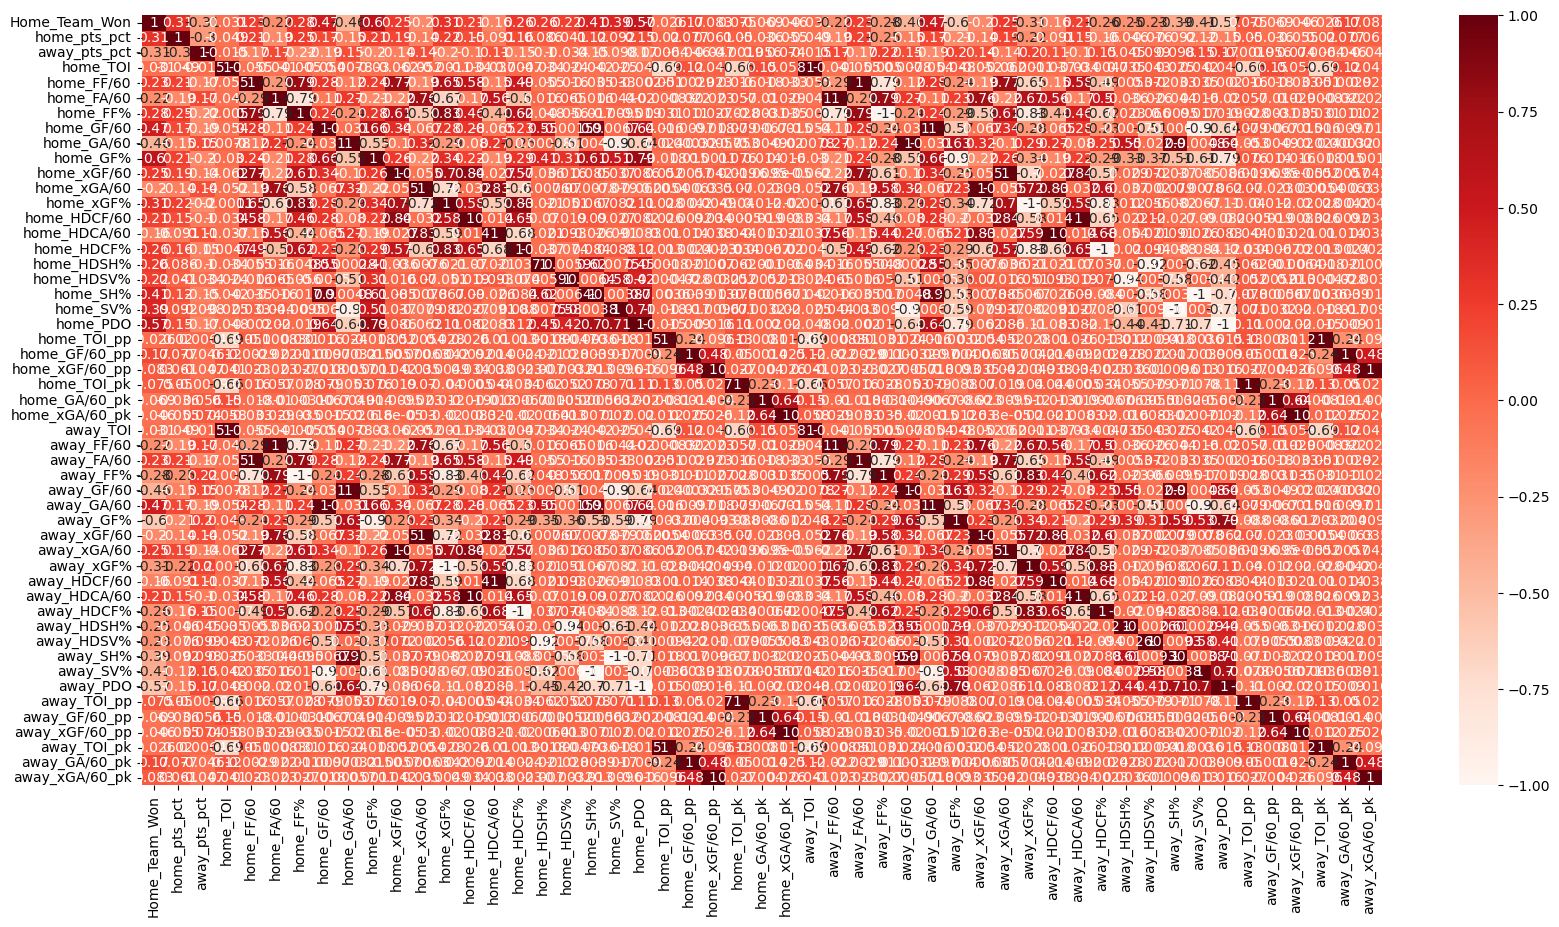

In [10]:
# Check correlation of selected features
plt.figure(figsize=(20,10))
cor = modeling_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
# # Table of heatmap values
# modeling_df.corr().sort_values('Home_Team_Won') # ignore season_id

In [119]:
corr_df = modeling_df.corr().sort_values('Home_Team_Won') # ignore season_id
corr_df

,Home_Team_Won,home_pts_pct,away_pts_pct,home_TOI,home_FF/60,home_FA/60,home_FF%,home_GF/60,home_GA/60,home_GF%,home_xGF/60,home_xGA/60,home_xGF%,home_HDCF/60,home_HDCA/60,home_HDCF%,home_HDSH%,home_HDSV%,home_SH%,home_SV%,home_PDO,home_TOI_pp,home_GF/60_pp,home_xGF/60_pp,home_TOI_pk,home_GA/60_pk,home_xGA/60_pk,away_TOI,away_FF/60,away_FA/60,away_FF%,away_GF/60,away_GA/60,away_GF%,away_xGF/60,away_xGA/60,away_xGF%,away_HDCF/60,away_HDCA/60,away_HDCF%,away_HDSH%,away_HDSV%,away_SH%,away_SV%,away_PDO,away_TOI_pp,away_GF/60_pp,away_xGF/60_pp,away_TOI_pk,away_GA/60_pk,away_xGA/60_pk
away_GF%,-0.599544,-0.207479,0.196330,0.047650,-0.239146,0.228527,-0.291547,-0.572845,0.631991,-0.899743,-0.253725,0.232837,-0.344472,-0.196734,0.214650,-0.294683,-0.345242,-0.361695,-0.526348,-0.590821,-0.791560,-0.003241,-0.003981,0.009349,-0.087827,-0.008636,-0.011899,0.047650,0.228527,-0.239146,0.291547,0.631991,-0.572845,1.000000,0.232837,-0.253725,0.344472,0.214650,-0.196734,0.294683,0.394039,0.307241,0.590821,0.526348,0.791560,-0.087827,-0.008636,-0.011899,-0.003241,-0.003981,0.009349
away_PDO,-0.567670,-0.148274,0.173449,0.047804,0.001971,-0.019610,0.019134,-0.643301,0.638375,-0.792407,-0.086092,0.061702,-0.105405,-0.082468,0.083431,-0.121824,-0.445838,-0.419038,-0.704524,-0.707018,-1.000000,0.014956,0.009004,0.015955,-0.105642,-0.001989,-0.019569,0.047804,-0.019610,0.001971,-0.019134,0.638375,-0.643301,0.791560,0.061702,-0.086092,0.105405,0.083431,-0.082468,0.121824,0.437913,0.406268,0.707018,0.704524,1.000000,-0.105642,-0.001989,-0.019569,0.014956,0.009004,0.015955
home_GA/60,-0.455510,-0.147103,0.149462,0.007840,-0.122315,0.269732,-0.240865,-0.031082,1.000000,-0.549068,-0.102017,0.323574,-0.293418,-0.080265,0.274380,-0.248288,0.000276,-0.512497,0.004810,-0.904281,-0.638375,0.024202,0.000321,0.000566,-0.052826,-0.004895,-0.019836,0.007840,0.269732,-0.122315,0.240865,1.000000,-0.031082,0.631991,0.323574,-0.102017,0.293418,0.274380,-0.080265,0.248288,0.548959,-0.021792,0.904281,-0.004810,0.638375,-0.052826,-0.004895,-0.019836,0.024202,0.000321,0.000566
away_GF/60,-0.455510,-0.147103,0.149462,0.007840,-0.122315,0.269732,-0.240865,-0.031082,1.000000,-0.549068,-0.102017,0.323574,-0.293418,-0.080265,0.274380,-0.248288,0.000276,-0.512497,0.004810,-0.904281,-0.638375,0.024202,0.000321,0.000566,-0.052826,-0.004895,-0.019836,0.007840,0.269732,-0.122315,0.240865,1.000000,-0.031082,0.631991,0.323574,-0.102017,0.293418,0.274380,-0.080265,0.248288,0.548959,-0.021792,0.904281,-0.004810,0.638375,-0.052826,-0.004895,-0.019836,0.024202,0.000321,0.000566
away_SV%,-0.410017,-0.117491,0.147067,0.042498,0.035409,0.016086,0.017470,-0.902947,-0.004810,-0.611950,-0.084883,0.007808,-0.066564,-0.089976,0.026361,-0.083623,-0.622819,-0.006435,-1.000000,0.003759,-0.704524,0.003592,-0.003903,0.012812,-0.078463,0.000561,-0.007086,0.042498,0.016086,0.035409,-0.017470,-0.004810,-0.902947,0.526348,0.007808,-0.084883,0.066564,0.026361,-0.089976,0.083623,0.002944,0.583800,-0.003759,1.000000,0.704524,-0.078463,0.000561,-0.007086,0.003592,-0.003903,0.012812
away_SH%,-0.391314,-0.091787,0.097904,0.024981,-0.032620,-0.043672,0.009484,-0.006682,0.904281,-0.506695,-0.036802,0.079045,-0.082184,-0.026528,0.091234,-0.088283,-0.007515,-0.583998,0.003759,-1.000000,-0.707018,0.017539,0.016585,0.009624,-0.070599,-0.003235,-0.020478,0.024981,-0.043672,-0.032620,-0.009484,0.904281,-0.006682,0.590821,0.079045,-0.036802,0.082184,0.091234,-0.026528,0.088283,0.614051,-0.009304,1.000000,-0.003759,0.707018,-0.070599,-0.003235,-0.020478,0.017539,0.016585,0.009624
away_pts_pct,-0.309084,-0.299474,1.000000,-0.015278,-0.166939,0.174660,-0.215557,-0.190705,0.149462,-0.199982,-0.135289,0.142496,-0.199874,-0.099663,0.112092,-0.148598,-0.102978,-0.034100,-0.147067,-0.097904,-0.173449,0.006442,-0.045646,-0.046846,-0.001900,0.056362,0.073780,-0.015278,0.174660,-0.166939,0.215557,0.149462,-0.190705,0.196330,0.142496,-0.135289,0.199874,0.112092,-0.099663,0.148598,0.044664,0.098652,0.097904,0.147067,0.173449,-0

- there are a lot of mirrored values as we have the home and away perspectictive
- which do we delete?
- isolate away variation for now

NEED to shift stats back one game so that this is predicting future games vs in game win probability

In [136]:
print(corr_df.index.to_list)

<bound method IndexOpsMixin.tolist of Index(['away_GF%', 'away_PDO', 'home_GA/60', 'away_GF/60', 'away_SV%',
       'away_SH%', 'away_pts_pct', 'away_xGF%', 'away_FF%', 'away_HDCF%',
       'away_HDSH%', 'away_HDSV%', 'home_FA/60', 'away_FF/60', 'away_xGF/60',
       'home_xGA/60', 'home_HDCA/60', 'away_HDCF/60', 'home_GA/60_pk',
       'away_GF/60_pp', 'away_xGF/60_pp', 'home_xGA/60_pk', 'home_TOI',
       'away_TOI', 'home_TOI_pp', 'away_TOI_pk', 'away_TOI_pp', 'home_TOI_pk',
       'away_xGA/60_pk', 'home_xGF/60_pp', 'home_GF/60_pp', 'away_GA/60_pk',
       'home_HDCF/60', 'away_HDCA/60', 'home_HDSV%', 'away_FA/60',
       'home_FF/60', 'home_xGF/60', 'away_xGA/60', 'home_HDSH%', 'home_HDCF%',
       'home_FF%', 'home_xGF%', 'home_pts_pct', 'home_SV%', 'home_SH%',
       'home_GF/60', 'away_GA/60', 'home_PDO', 'home_GF%', 'Home_Team_Won'],
      dtype='object')>


In [130]:
mirrored_stats = ['away_GF/60', 'away_FF/60', 'away_xGF/60', 'away_HDCF/60', 'away_GF/60_pp', 'away_xGF/60_pp', 
                 'away_TOI', 'away_TOI_pk', 'away_TOI_pp', 'away_xGA/60_pk', 'away_GA/60_pk', 'away_HDCA/60',
                  'away_FA/60', 'away_xGA/60','away_GA/60']

,Home_Team_Won
away_GF%,-0.599544
away_PDO,-0.567670
home_GA/60,-0.455510
away_GF/60,-0.455510
away_SV%,-0.410017
away_SH%,-0.391314
away_pts_pct,-0.309084
away_xGF%,-0.308746
away_FF%,-0.275023
away_HDCF%,-0.261105


In [141]:
# home_PDO and home_GF% are the absolute value of the away variation
# drill down to examine further
abs_fields = modeling_df[['home_PDO', 'away_PDO', 'home_GF%', 'away_GF%']]
abs_fields

,home_PDO,away_PDO,home_GF%,away_GF%
0,0.975,1.025,55.27,44.73
1,1.014,0.986,48.19,51.81
2,1.062,0.938,57.61,42.39
3,1.013,0.987,66.09,33.91
4,1.064,0.936,65.64,34.36
...,...,...,...,...
3257,1.008,0.992,47.45,52.55
3258,1.003,0.997,46.65,53.35
3259,1.068,0.932,100.00,0.00
3260,1.087,0.913,52.18,47.82


PDO:
- home and away PDO always sum to 2, but are not equal
- contains info about actual goals and shots for and against
- this is clearly useful information to capture, but given the fixed relationship we might not need both

GF%
- home and away values are inverses of each other
- will look to handle similarly to PDO

## Baseline 

### Naive Choice

Choose the home team to win every time

### Basic Logistic Regression

In [12]:
# Use 2019-2020 and 2020-2021 for training
# Use 2021-2022 for test set 
X_train = modeling_df.loc[modeling_df['season_id'] != '20212022'].drop(['season_id', 'Home_Team_Won'], axis=1)
y_train = modeling_df.loc[modeling_df['season_id'] != '20212022']['Home_Team_Won']
X_test = modeling_df.loc[modeling_df['season_id'] == '20212022'].drop(['season_id', 'Home_Team_Won'], axis=1)
y_test = modeling_df.loc[modeling_df['season_id'] == '20212022']['Home_Team_Won']

In [21]:
# Check df shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape) 
# shape align, but the split is very close to 50/50 because of covid -  might need to reach back one more year

(1950, 50)
(1950,)
(1312, 50)
(1312,)


In [22]:
X_test

,home_pts_pct,away_pts_pct,home_TOI,home_FF/60,home_FA/60,home_FF%,home_GF/60,home_GA/60,home_GF%,home_xGF/60,home_xGA/60,home_xGF%,home_HDCF/60,home_HDCA/60,home_HDCF%,home_HDSH%,home_HDSV%,home_SH%,home_SV%,home_PDO,home_TOI_pp,home_GF/60_pp,home_xGF/60_pp,home_TOI_pk,home_GA/60_pk,home_xGA/60_pk,away_TOI,away_FF/60,away_FA/60,away_FF%,away_GF/60,away_GA/60,away_GF%,away_xGF/60,away_xGA/60,away_xGF%,away_HDCF/60,away_HDCA/60,away_HDCF%,away_HDSH%,away_HDSV%,away_SH%,away_SV%,away_PDO,away_TOI_pp,away_GF/60_pp,away_xGF/60_pp,away_TOI_pk,away_GA/60_pk,away_xGA/60_pk
1950,0.000000,1.000000,53.900000,32.64,53.24,38.00,0.00,3.54,0.00,1.32,3.08,30.01,3.87,14.71,20.83,0.00,80.38,0.00,90.78,0.908,2.000000,0.00,6.50,2.000000,0.00,0.00,53.900000,53.24,32.64,62.00,3.54,0.00,100.00,3.08,1.32,69.99,14.71,3.87,79.17,19.62,100.00,9.22,100.00,1.092,2.000000,0.00,0.00,2.000000,0.00,6.50
1951,1.000000,0.000000,45.716667,45.29,48.69,48.19,5.07,3.98,56.03,2.96,2.74,51.95,10.43,14.41,41.98,41.18,58.00,17.65,87.78,1.054,6.000000,0.00,12.34,4.700000,0.00,3.44,45.716667,48.69,45.29,51.81,3.98,5.07,43.97,2.74,2.96,48.05,14.41,10.43,58.02,42.00,58.82,12.22,82.35,0.946,4.700000,0.00,3.44,6.000000,0.00,12.34
1952,1.000000,0.000000,47.966667,52.57,39.43,57.14,1.18,1.32,47.18,3.38,2.28,59.66,17.55,9.25,65.49,0.00,83.09,4.01,95.83,0.998,4.483333,13.38,10.26,4.533333,0.00,5.10,47.966667,39.43,52.57,42.86,1.32,1.18,52.82,2.28,3.38,40.34,9.25,17.55,34.51,16.91,100.00,4.17,95.99,1.002,4.533333,0.00,5.10,4.483333,13.38,10.26
1953,1.000000,0.000000,42.500000,40.03,26.81,59.89,1.39,0.00,100.00,1.74,1.64,51.44,4.27,1.42,75.12,0.00,100.00,5.52,100.00,1.055,6.300000,28.57,6.45,6.900000,8.70,12.10,42.500000,26.81,40.03,40.11,0.00,1.39,0.00,1.64,1.74,48.56,1.42,4.27,24.88,0.00,100.00,0.00,94.48,0.945,6.900000,8.70,12.10,6.300000,28.57,6.45
1954,1.000000,0.000000,39.533333,28.64,43.96,39.44,2.93,1.54,65.57,1.83,2.38,43.39,10.54,6.01,63.69,19.56,100.00,15.28,94.28,1.096,7.200000,16.67,13.03,8.750000,0.00,9.88,39.533333,43.96,28.64,60.56,1.54,2.93,34.43,2.38,1.83,56.61,6.01,10.54,36.31,0.00,80.44,5.72,84.72,0.904,8.750000,0.00,9.88,7.200000,16.67,13.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,0.597561,0.463415,54.450000,32.22,30.41,51.44,2.06,2.28,47.45,2.21,1.37,61.63,11.32,5.80,66.12,51.77,50.19,12.11,88.68,1.008,2.566667,23.38,1.87,2.000000,0.00,7.57,54.450000,30.41,32.22,48.56,2.28,2.06,52.55,1.37,2.21,38.37,5.80,11.32,33.88,49.81,48.23,11.32,87.89,0.992,2.000000,0.00,7.57,2.566667,23.38,1.87
3258,0.634146,0.560976,53.783333,39.31,51.30,43.38,2.06,2.36,46.65,2.56,3.93,39.47,13.96,12.29,53.19,0.00,100.00,7.13,93.16,1.003,2.000000,0.00,12.50,4.000000,0.00,17.36,53.783333,51.30,39.31,56.62,2.36,2.06,53.35,3.93,2.56,60.53,12.29,13.96,46.81,0.00,100.00,6.84,92.87,0.997,4.000000,0.00,17.36,2.000000,0.00,12.50
3259,0.370370,0.469512,52.416667,48.21,26.93,64.16,2.21,0.00,100.00,2.42,1.42,62.98,11.58,4.54,71.82,0.00,100.00,6.82,100.00,1.068,2.000000,0.00,12.69,1.600000,0.00,11.05,52.416667,26.93,48.21,35.84,0.00,2.21,0.00,1.42,2.42,37.02,4.54,11.58,28.18,0.00,100.00,0.00,93.18,0.932,1.600000,0.00,11.05,2.000000,0.00,12.69
3260,0.347561,0.591463,48.750000,31.75,58.08,35.34,5.73,5.25,52.18,1.60,3.01,34.78,4.30,13.88,23.67,52.52,51.84,25.11,83.60,1.087,5.950000,0.00,15.61,3.950000,0.00,9.76,48.750000,58.08,31.75,64.66,5.25,5.73,47.82,3.01,1.60,65.22,13.88,4.30,76.33,48.16,47.48,16.40,74.89,0.913,3.950000,0.00,9.76,5.950000,0.00,15.61


- Currently we don't have any categorical features
- will leave the code for categorical features in but commented out in case it's needed in the future

In [13]:
# Assign training sets of numeric and categorical columns to respective variables
num_features = X_train.select_dtypes(['int', 'float']).columns
cat_features = X_train.select_dtypes(['object']).columns # no cat features

In [14]:
# Establish pipelines for each feature type
numeric_pipeline = Pipeline([('ss', StandardScaler())])

nominal_pipeline = Pipeline([
    ('onehotenc', OneHotEncoder(handle_unknown = 'ignore')), 
    ('onehotnorm', MaxAbsScaler())])

# declare scoring metric list
scoring = ['neg_log_loss', 'accuracy']

# declare random stame value
rnd = 42

In [16]:
# Instantiate the column transformer 
ct = ColumnTransformer(transformers=
    [("numpipe", numeric_pipeline, num_features),
     ("nominalpipe", nominal_pipeline, cat_features)])

In [145]:
# build baseline log reg pipepline 
steps = [('preprocess', ct), 
         ('logreg', LogisticRegression(random_state = rnd, max_iter=10000))]

base_log_reg_pipeline = Pipeline(steps)

base_log_reg_pipeline.fit(X_train, y_train)

# Predict using the pipeline 
base_log_y_pred = base_log_reg_pipeline.predict(X_test)

In [117]:
# Evaluate the accuracy of the predictions
accuracy = accuracy_score(y_test, base_log_y_pred)
print(f'Test accuracy: {accuracy:.3f}')

# Calculate the F1 score for the test set
f1 = f1_score(y_test, base_log_y_pred,average='macro')
print(f'Test F1 score: {f1:.3f}')

# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')

# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')

Test accuracy: 0.856
Test F1 score: 0.855
Test AUC-ROC score: 0.935
Test log loss score: 0.339


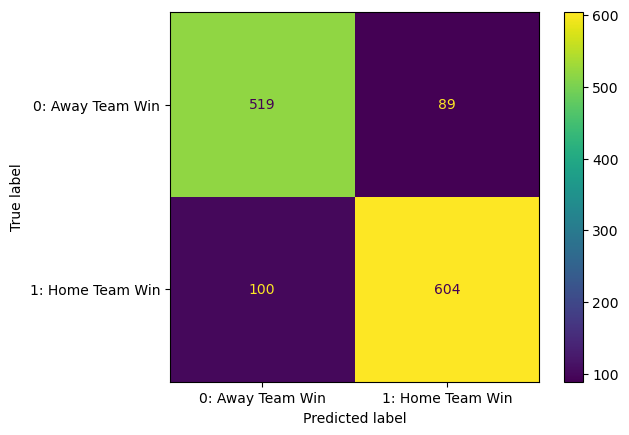

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       608
           1       0.87      0.86      0.86       704

    accuracy                           0.86      1312
   macro avg       0.86      0.86      0.86      1312
weighted avg       0.86      0.86      0.86      1312

Test log loss score: 0.339
Test AUC-ROC score: 0.935


In [118]:
# Calculate the confusion matrix
label_names = ['0: Away Team Win', '1: Home Team Win']
cm = confusion_matrix(y_test, base_log_y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, base_log_y_pred)
print(f'Classification report:\n{report}')
# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')# Calculate the AUC-ROC score for the test set
# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')

### Logistic Regression Grid Search v1

In [161]:
# set up grid search
# pipeline steps remain the same
steps = [('preprocess', ct), 
         ('logreg', LogisticRegression(random_state=42, max_iter=10000))]

log_cv_pipeline = Pipeline(steps)

log_cv_params = {'logreg__solver' : ['liblinear', 'lbfgs', 'newton-cg'],
                'logreg__penalty': ['None', 'l1', 'l2'],
                'logreg__C': [0.1, 10, 20, 100],
                'logreg__class_weight': [None] }

log_cv = GridSearchCV(log_cv_pipeline, param_grid=log_cv_params, cv=5, scoring=scoring, 
                      refit = 'neg_log_loss', verbose=1)

In [162]:
log_cv.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['home_pts_pct', 'away_pts_pct', 'home_TOI', 'home_FF/60', 'home_FA/60',
       'home_FF%', 'home_GF/60', 'home_GA/60', 'home_GF%', 'home_xGF/60',
       'home_xGA/60', 'home_xGF%', 'home_HDCF/60', 'home_HDCA/60',
       'home_HDCF%', 'h...
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         Index([], dtype='object'))])),
                                       ('logreg',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42))]),
             param_grid={'logreg__C': [0.1, 10, 20, 100],
                         'logreg__class_weight': [None],
                         'logreg__penalty': ['None', 'l1', 'l2'],
                         'logreg__solver': ['liblinear', 'lbfgs', 'newton-cg']},
             refit='neg_log_loss', scoring=['neg_log_loss', 'accuracy'],
             verbose=1)

In [163]:
log_cv.best_score_

-0.36110490714177435

In [164]:
log_results = pd.DataFrame(log_cv.cv_results_).sort_values('mean_test_neg_log_loss', ascending=False)
log_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_logreg__class_weight,param_logreg__penalty,param_logreg__solver,params,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
3,0.007481,0.000686,0.002450,0.000141,0.1,None,l1,liblinear,"{'logreg__C': 0.1, 'logreg__class_weight': Non...",-0.364385,-0.381929,-0.353010,-0.358388,-0.347812,-0.361105,0.011782,1,0.820513,0.853846,0.838462,0.861538,0.851282,0.845128,0.014377,2
7,0.012287,0.000808,0.002703,0.000108,0.1,None,l2,lbfgs,"{'logreg__C': 0.1, 'logreg__class_weight': Non...",-0.364035,-0.382297,-0.353220,-0.365068,-0.353087,-0.363541,0.010679,2,0.815385,0.848718,0.835897,0.853846,0.851282,0.841026,0.014230,15
8,0.019296,0.000165,0.002733,0.000205,0.1,None,l2,newton-cg,"{'logreg__C': 0.1, 'logreg__class_weight': Non...",-0.364036,-0.382297,-0.353221,-0.365067,-0.353092,-0.363543,0.010678,3,0.815385,0.848718,0.835897,0.853846,0.851282,0.841026,0.014230,15
6,0.007769,0.000310,0.002387,0.000075,0.1,None,l2,liblinear,"{'logreg__C': 0.1, 'logreg__class_weight': Non...",-0.364051,-0.381692,-0.353778,-0.364755,-0.353630,-0.363581,0.010244,4,0.812821,0.848718,0.835897,0.856410,0.853846,0.841538,0.016005,14
12,0.038720,0.010321,0.002492,0.000160,10,None,l1,liblinear,"{'logreg__C': 10, 'logreg__class_weight': None...",-0.366220,-0.389667,-0.347670,-0.366922,-0.352327,-0.364561,0.014654,5,0.823077,0.856410,0.848718,0.851282,0.848718,0.845641,0.011626,1
21,0.066629,0.015668,0.002533,0.000114,20,None,l1,liblinear,"{'logreg__C': 20, 'logreg__class_weight': None...",-0.366554,-0.389896,-0.348218,-0.367236,-0.352420,-0.364865,0.014608,6,0.823077,0.856410,0.848718,0.848718,0.846154,0.844615,0.011305,3
17,0.033673,0.002121,0.002547,0.000063,10,None,l2,newton-cg,"{'logreg__C': 10, 'logreg__class_weight': None...",-0.366775,-0.389855,-0.348647,-0.367368,-0.352452,-0.365019,0.014501,7,0.820513,0.856410,0.848718,0.848718,0.846154,0.844103,0.012286,4
16,0.029668,0.002587,0.002362,0.000035,10,None,l2,lbfgs,"{'logreg__C': 10, 'logreg__class_weight': None...",-0.366769,-0.389852,-0.348670,-0.367366,-0.352451,-0.365022,0.014495,8,0.820513,0.856410,0.848718,0.848718,0.846154,0.844103,0.012286,4
15,0.014572,0.000545,0.002386,0.000059,10,None,l2,liblinear,"{'logreg__C': 10, 'logreg__class_weight': None...",-0.366801,-0.389851,-0.348659,-0.367363,-0.352459,-0.365027,0.014496,9,0.820513,0.856410,0.848718,0.848718,0.846154,0.844103,0.012286,4
25,0.037975,0.006118,0.002385,0.000063,20,None,l2,lbfgs,"{'logreg__C': 20, 'logreg__class_weight': None...",-0.366860,-0.389953,-0.348690,-0.367429,-0.352440,-0.365074,0.014531,10,0.820513,0.856410,0.848718,0.848718,0.846154,0.844103,0.012286,4


### Logistic Regression Grid Search v2

In [ ]:
# Regression CV
scores = []
models = []

In [166]:
%time

# Regression CV
scores = []
models = []

# Parameters
steps = [('preprocess', ct), 
         ('logreg', LogisticRegression(random_state=42, max_iter=10000))]

log_cv_pipeline = Pipeline(steps)

logreg_params = {'logreg__solver' : ['liblinear'],
                'logreg__penalty': ['l1', 'l2'],
                'logreg__C': [0.1, 10, 20, 100],
                'logreg__max_iter': [100,1000,10000] }

# Model
logreg_top_model_pipe = Pipeline(steps)

logreg_top_model = GridSearchCV(estimator=logreg_top_model_pipe, param_grid=logreg_params, 
                                scoring=scoring, refit = 'neg_log_loss', cv=5, verbose=1)
logreg_top_model.fit(X_train, y_train)

# Displaying Data
y_pred = logreg_top_model.predict(X_test)
logreg_top_score = logreg_top_model.score(X_test, y_test)

# Model Selection
for i in range(0, 11):
    print(f"Model {i}. Current Top Score: {logreg_top_score}")
            
    # Model Building
    logreg_cur_pipe = Pipeline(steps)
    logreg_cur_gs = GridSearchCV(estimator=logreg_cur_pipe, param_grid=logreg_params, 
                                 scoring=scoring, refit = 'neg_log_loss', cv=5, verbose=1)
    logreg_cur_gs.fit(X_train, y_train)
    
    # Comparing and Replacing Data
    y_pred = logreg_cur_gs.predict(X_test)
    logreg_cur_score = logreg_cur_gs.score(X_test, y_test)
    
    if logreg_cur_score > logreg_top_score:
        logreg_top_model = logreg_cur_gs
        logreg_top_score = logreg_cur_score

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 13.1 µs
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Model 0. Current Top Score: -0.33204738294671493
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Model 1. Current Top Score: -0.33204738294671493
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Model 2. Current Top Score: -0.33204738294671493
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Model 3. Current Top Score: -0.33204738294671493
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Model 4. Current Top Score: -0.33204738294671493
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Model 5. Current Top Score: -0.33204738294671493
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Model 6. Current Top Score: -0.33204738294671493
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Model 7. Current Top Score: -0.33204738294671493
Fitting 5 folds for each of 24 candidates, total


Logistic Regression Top Score: -0.33204738294671493

Best Parameters:
logreg__C: 0.1
logreg__max_iter: 100
logreg__penalty: l1
logreg__solver: liblinear

Cross Validation
Summary Statistics:
               0
count  10.000000
mean   -0.342232
std     0.028360
min    -0.387646
25%    -0.365821
50%    -0.336683
75%    -0.324910
max    -0.303423



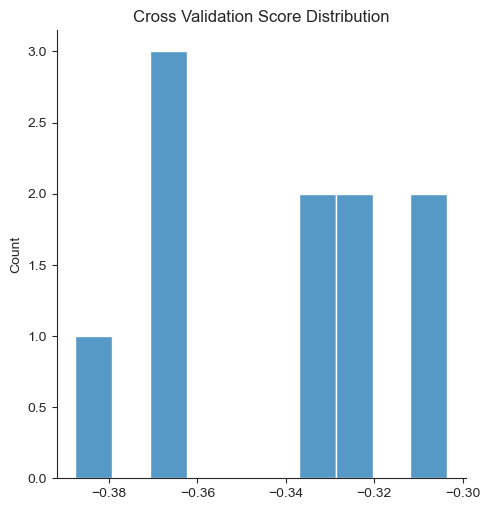

In [178]:
# Append top score and top model
scores.append(logreg_top_score)
models.append(logreg_top_model)
        
# Displaying Data
print(f"\nLogistic Regression Top Score: {logreg_top_score}\n")
print("Best Parameters:")
for key, value in list(logreg_top_model.best_params_.items()): print(f"{key}: {value}")

logreg_cv = cross_val_score(logreg_top_model, X = modeling_df.drop(['season_id', 'Home_Team_Won'], axis=1), 
                            y = modeling_df['Home_Team_Won'], cv=10, n_jobs=-1)
logreg_cv_df = pd.DataFrame(logreg_cv)
print("\nCross Validation\nSummary Statistics:")
print(f"{logreg_cv_df.describe().to_string()}\n")

sns.displot(logreg_cv, bins=10)
sns.set_style("ticks")
plt.title("Cross Validation Score Distribution")
plt.show()

### Gradient Booster

booster 1

In [171]:
gb_pipeline = Pipeline(steps=[('preprocess', ct),
                      ('gb', GradientBoostingClassifier(random_state=42))])

gb_params = {'gb__n_estimators': [200, 300, 400],
         'gb__learning_rate': [.001,.01, .1],
         'gb__max_depth' : [3,5]}

gb_cv = GridSearchCV(gb_pipeline, param_grid=gb_params, cv=5, scoring=scoring, refit='neg_log_loss', verbose=1)

In [172]:
gb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['home_pts_pct', 'away_pts_pct', 'home_TOI', 'home_FF/60', 'home_FA/60',
       'home_FF%', 'home_GF/60', 'home_GA/60', 'home_GF%', 'home_xGF/60',
       'home_xGA/60', 'home_xGF%', 'home_HDCF/60', 'home_HDCA/60',
       'home_HDCF%', 'h...
                                                                         Pipeline(steps=[('onehotenc',
                                                                                          OneHotEncoder(handle_unknown='ignore')),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         Index([], dtype='object'))])),
                                       ('gb',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'gb__learning_rate': [0.001, 0.01, 0.1],
                         'gb__max_depth': [3, 5],
                         'gb__n_estimators': [200, 300, 400]},
             refit='neg_log_loss', scoring=['neg_log_loss', 'accuracy'],
             verbose=1)

In [173]:
gb_cv.best_score_

-0.30937368575177937

In [174]:
gb_results = pd.DataFrame(gb_cv.cv_results_).sort_values('mean_test_neg_log_loss', ascending=False)
gb_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gb__learning_rate,param_gb__max_depth,param_gb__n_estimators,params,split0_test_neg_log_loss,split1_test_neg_log_loss,split2_test_neg_log_loss,split3_test_neg_log_loss,split4_test_neg_log_loss,mean_test_neg_log_loss,std_test_neg_log_loss,rank_test_neg_log_loss,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
12,2.444213,0.006379,0.005080,0.000139,0.1,3,200,"{'gb__learning_rate': 0.1, 'gb__max_depth': 3,...",-0.353748,-0.300160,-0.270922,-0.319852,-0.302186,-0.309374,0.027180,1,0.866667,0.861538,0.884615,0.858974,0.861538,0.866667,0.009316,6
11,7.811809,0.052949,0.011170,0.000452,0.01,5,400,"{'gb__learning_rate': 0.01, 'gb__max_depth': 5...",-0.386269,-0.285233,-0.282272,-0.319555,-0.296626,-0.313991,0.038444,2,0.841026,0.889744,0.869231,0.858974,0.864103,0.864615,0.015756,8
8,4.850873,0.004295,0.007882,0.000156,0.01,3,400,"{'gb__learning_rate': 0.01, 'gb__max_depth': 3...",-0.360809,-0.294642,-0.301058,-0.321980,-0.298693,-0.315436,0.024580,3,0.851282,0.884615,0.879487,0.861538,0.874359,0.870256,0.012200,2
13,3.661794,0.002410,0.006125,0.000042,0.1,3,300,"{'gb__learning_rate': 0.1, 'gb__max_depth': 3,...",-0.371076,-0.313759,-0.278061,-0.333219,-0.310330,-0.321289,0.030550,4,0.864103,0.856410,0.876923,0.861538,0.866667,0.865128,0.006803,7
10,5.873220,0.070303,0.008990,0.000171,0.01,5,300,"{'gb__learning_rate': 0.01, 'gb__max_depth': 5...",-0.389613,-0.295039,-0.293435,-0.327070,-0.305907,-0.322213,0.035774,5,0.830769,0.887179,0.864103,0.858974,0.866667,0.861538,0.018131,9
7,3.722074,0.105064,0.006596,0.000162,0.01,3,300,"{'gb__learning_rate': 0.01, 'gb__max_depth': 3...",-0.371390,-0.309679,-0.319898,-0.338080,-0.314745,-0.330759,0.022464,6,0.841026,0.876923,0.866667,0.853846,0.861538,0.860000,0.012092,11
14,4.880302,0.005427,0.007233,0.000179,0.1,3,400,"{'gb__learning_rate': 0.1, 'gb__max_depth': 3,...",-0.393722,-0.326428,-0.291357,-0.349422,-0.326142,-0.337414,0.033716,7,0.864103,0.864103,0.874359,0.866667,0.866667,0.867179,0.003768,5
9,3.878138,0.005881,0.007028,0.000146,0.01,5,200,"{'gb__learning_rate': 0.01, 'gb__max_depth': 5...",-0.400536,-0.315743,-0.314402,-0.346330,-0.326365,-0.340675,0.032038,8,0.817949,0.884615,0.874359,0.864103,0.864103,0.861026,0.022842,10
6,2.430673,0.006111,0.005441,0.000086,0.01,3,200,"{'gb__learning_rate': 0.01, 'gb__max_depth': 3...",-0.397539,-0.342401,-0.353935,-0.371804,-0.351061,-0.363348,0.019590,9,0.828205,0.874359,0.851282,0.848718,0.853846,0.851282,0.014685,12
15,3.961067,0.027220,0.006896,0.000207,0.1,5,200,"{'gb__learning_rate': 0.1, 'gb__max_depth': 5,...",-0.470260,-0.321982,-0.325812,-0.379522,-0.385615,-0.376638,0.053711,10,0.858974,0.900000,0.876923,0.866667,0.861538,0.872821,0.014916,1


## Neural Network

In [35]:
def build_model(optimizer='adam', activation='linear', neurons = 36, dropout_rate=0.3, weight_constraint=3):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_dim=50, kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation=activation))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# define the grid search parameters

param_grid = {'nn__epochs': [8, 10, 12],
             'nn__optimizer' : ['RMSprop', 'Adam'], 
             'nn__activation' : ['sigmoid', 'linear'],
            'nn__neurons' : [12, 18, 24, 30, 36],
             'nn__weight_constraint': [1, 3, 5],
             'nn__dropout_rate' : [0.0, 0.3, 0.6,]}

#wrap neural network in scikit learn wrapper
keras_model = scikit_learn.KerasClassifier(build_fn=build_model, verbose=0)

steps = [('preprocess', ct), 
        ('nn', keras_model)]

nn_pipeline = Pipeline(steps)

nn_cv = GridSearchCV(estimator=nn_pipeline, param_grid=param_grid, cv=3, scoring=scoring, refit='neg_log_loss', verbose=1)

In [36]:
nn_cv.fit(X_train, y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


2023-04-18 13:29:27.925791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-18 13:30:27.309248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 27ms/step


2023-04-18 13:30:30.291578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-18 13:31:28.182328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 48ms/step


2023-04-18 13:31:33.082590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-18 13:32:35.013394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 3ms/step


2023-04-18 13:32:38.199358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-18 13:33:42.092613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 2ms/step


2023-04-18 13:33:46.637545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-18 13:34:51.832251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 43ms/step


2023-04-18 13:34:56.315902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-18 13:35:54.177609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 48ms/step


2023-04-18 13:35:58.917326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-18 13:37:03.213991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 3ms/step


2023-04-18 13:37:07.215294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-18 13:38:16.727318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 49ms/step


2023-04-18 13:38:21.862875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [25]:
nn_results = pd.DataFrame(nn_cv.cv_results_).sort_values('mean_test_neg_log_loss', ascending=False)
nn_results.head(5)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [ ]:
# monitor training performance
from numpy import loadtxt

from sklearn.metrics import accuracy_score
# load data
dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)
# fit model no training data
model = XGBClassifier()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:

import xgboost as xgb

xgb_cl = xgb.XGBClassifier()

In [181]:
# Defining the baseline model  without tuning any parameter
model = XGBClassifier(random_state=42)
results = cross_validate(model, X_train, y_train, cv=5,
                         return_train_score=True, scoring="neg_log_loss")
                         
# Getting the mean score of the 5 folds (either from train and test)
baseline_mean_train_score = np.multiply(results["train_score"], -1).mean()
baseline_mean_test_score = np.multiply(results["test_score"], -1).mean()

#Step 2: Use GridSearchCV for improving the baseline

# Defining the parameters grid
parameters_grid = {'max_depth': [4, 5, 6], 
                   'learning_rate': [0.1, 0.2, 0.3],
                   'n_estimators': [50, 100, 150], 
                   'gamma': [0, 20], 
                   'subsample': [0.8, 1], 
                   'colsample_bytree': [0.8, 1], 
                   'lambda': [0, 0.1, 1],
                   'tree_method': ["hist"],
                   'eval_metric': ["mae"]}

# Define the model to use with GridSearch
xgboost = XGBClassifier(random_state=42)

# Use GridSearchCV along XGBoost to find the best parameter combination
xgb_gscv = GridSearchCV(xgboost, parameters_grid, cv=5, scoring="neg_log_loss", return_train_score=True)
xgb_gscv.fit(X_train, y_train)

# Get and process the results
cv_results = xgb_gscv.cv_results_
cv_results = pd.concat([pd.DataFrame(cv_results["params"]),
                        pd.DataFrame(cv_results["mean_test_score"], columns=["test_mean_mae"]),
                        pd.DataFrame(cv_results["mean_train_score"], columns=["train_mean_mae"])],
                       axis=1)
cv_results.sort_values(by="test_mean_mae", ascending=False)

# Now the baseline has changed
best_score = abs(cv_results.sort_values(by="test_mean_mae", ascending=False).iloc[0]["test_mean_mae"])

#Step 3: Tune parameters individually


def get_cross_validate_scores(df_scores, feature, value, model, X_train, y_train, best_score, metric="neg_mean_absolute_error"):
    # Train the model with cross_validation and get the results
    results = cross_validate(model, X_train, y_train, cv=5,
                             return_train_score=True, scoring=metric)
    # Calculate the metrics
    mean_train_score = np.multiply(results["train_score"], -1).mean()
    mean_test_score = np.multiply(results["test_score"], -1).mean()
    
    # Create different rows to add to the scores.
    print(f"{feature}: {value} - Train Score: {mean_train_score} - Test Score: {mean_test_score}")
    
    train_row_df = pd.DataFrame.from_dict({"value": value,
                                           "train_test": "train",
                                           "score": (results["train_score"] * -1)})
    test_row_df = pd.DataFrame.from_dict({"value": value,
                                          "train_test": "test",
                                          "score": (results["test_score"] * -1)})
    baseline_row_df = pd.DataFrame.from_dict({"value": value,
                                              "train_test": "best_score",
                                              "score": [best_score]})
    # Add the scores obtained to the main dataframe
    df_scores = pd.concat([df_scores, train_row_df, test_row_df, baseline_row_df])
    
    return df_scores

def plot_parameter_scores(feature, df_scores):
    # Create the plot
    parameter_plot = sns.relplot(data=df_scores, x="value", y="score", kind="line", hue="train_test")
    
    # Set the titles and axis labels
    parameter_plot.set_titles(f"{feature} Parameter")
    parameter_plot.set_ylabels("MAE", clear_inner=False)
    parameter_plot.set_xlabels(f"{feature}", clear_inner=False)
    
# Defining the best parameters found with GridSearchCV
gscv_best_params = {"colsample_bytree": 0.8, "eval_metric": "mae",
                    "gamma": 0, "lambda": 1, "learning_rate": 0.1, 
                    "max_depth": 4, "n_estimators": 150, "subsample": 1.0, 
                    "random_state":42}

# Defining, for each parameter, a name without special characters and an array with the values to test
main_parameters_dict = {"n_estimators": ["N Estimators", [125, 150, 175, 200, 225]]}

# Iterating over the parameter dictionary
for parameter, arguments in main_parameters_dict.items():
    # Create an empty dataframe for the scores
    df_scores = pd.DataFrame(columns=["value", "train_test", "score"])
    
    print(f"{arguments[0]}\n")
    
    # Depending on the parameter, different models are built
    for parameter_value in arguments[1]:
        # Getting the best parameters found with GridSearchCV
        params_to_use = gscv_best_params.copy()
        # Adding the individual value of the parameter that we want to test
        params_to_use[parameter] = parameter_value
        
        # Create the XGBoost model with the parameters
        model = xgb.XGBClassifier().set_params(**params_to_use)
        
        # Adding the cross validate scores of a parameter value to the df_scores dataframe
        df_scores = get_cross_validate_scores(df_scores=df_scores, feature=arguments[0], value=parameter_value, model=model,
                                              X_train=X_train, y_train=y_train, best_score=best_score)
    
    # Plot the parameter scores
    plot_parameter_scores(arguments[0], df_scores)
    
    print("\n")

NameError: name 'xgb' is not defined

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConve

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConve

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConve

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConve

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConve

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jamesbenasuli/miniforge3/envs/sports/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConve

In [ ]:
# Step 4: Repeat steps 2 and 3.

# Using the information gathered before to define the parameters grid
parameters_grid = {'max_depth': [4, 5], 
                   'learning_rate': [0.05, 0.1, 0.15],
                   'n_estimators': [150, 300, 450], 
                   'gamma': [0, 20], 
                   'subsample': [0.7, 1], 
                   'colsample_bytree': [0.7, 1], 
                   'lambda': [0, 0.1, 1],
                   'tree_method': ["hist"],
                   'eval_metric': ["mae"]}

xgboost = xgb.XGBRegressor()

xgb_gscv = GridSearchCV(xgboost, parameters_grid, cv=5, scoring="neg_mean_absolute_error", return_train_score=True)
xgb_gscv.fit(X_train, y_train)

cv_results = xgb_gscv.cv_results_
cv_results = pd.concat([pd.DataFrame(cv_results["params"]),
                        pd.DataFrame(cv_results["mean_test_score"], columns=["test_mean_mae"]),
                        pd.DataFrame(cv_results["mean_train_score"], columns=["train_mean_mae"])],
                       axis=1)
cv_results.sort_values(by="test_mean_mae", ascending=False)

# Step 5: Use the test set to validate the model.

#Finally, we need to validate the model built with the test set 
# (holdout test, no validation test) of step 0.

# Calculate the Mean Absolute Error for the Test Set
test_mae = mean_absolute_error(y_true=y_test, y_pred=xgb_gscv.best_estimator_.predict(X_test))

In [ ]:
# build baseline trees pipeplin
steps = [('preprocess', ct), 
         ('rf', RandomForestClassifier(random_state = 42))]

rf_pipeline = Pipeline(steps)

rf_pipeline.fit(X_train, y_train)

In [ ]:
# Evaluate the accuracy of the predictions
accuracy = accuracy_score(y_test, base_log_y_pred)
print(f'Test accuracy: {accuracy:.3f}')

# Calculate the F1 score for the test set
f1 = f1_score(y_test, base_log_y_pred,average='macro')
print(f'Test F1 score: {f1:.3f}')

# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')

# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')

In [ ]:
# Logistic Regression w/ Grid Search

# Parameters
c = [0.1, 1, 10, 100]
max_iter = [100, 1000]
solver = ['liblinear']
penalty = ['l1', 'l2']

logreg_params = {
    'logreg__C': c,
    'logreg__max_iter': max_iter,
    'logreg__solver': solver,
    'logreg__penalty': penalty
}

# Model
logreg_top_model_pipe = Pipeline(steps=[("logreg", LogisticRegression(n_jobs=1))], verbose=False)
logreg_top_model = GridSearchCV(estimator=logreg_top_model_pipe, param_grid=logreg_params, scoring='accuracy', cv=5, verbose=0)
logreg_top_model.fit(X_train, y_train)

# Displaying Data
y_pred = logreg_top_model.predict(X_test)
logreg_top_score = logreg_top_model.score(X_test, y_test)

# Model Selection
for i in range(0, 11):
    print(f"Model {i}. Current Top Score: {logreg_top_score}")
        
    # Split X and y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
    
    # Model Building
    logreg_cur_pipe = Pipeline(steps=[("logreg", LogisticRegression(n_jobs=1))], verbose=False)
    logreg_cur_gs = GridSearchCV(estimator=logreg_cur_pipe, param_grid=logreg_params, scoring='accuracy', cv=5, verbose=0)
    logreg_cur_gs.fit(X_train, y_train)
    
    # Comparing and Replacing Data
    y_pred = logreg_cur_gs.predict(X_test)
    logreg_cur_score = logreg_cur_gs.score(X_test, y_test)
    
    if logreg_cur_score > logreg_top_score:
        logreg_top_model = logreg_cur_gs
        logreg_top_score = logreg_cur_score

Model 0. Current Top Score: 1.0
Model 1. Current Top Score: 1.0
Model 2. Current Top Score: 1.0
Model 3. Current Top Score: 1.0
Model 4. Current Top Score: 1.0
Model 5. Current Top Score: 1.0
Model 6. Current Top Score: 1.0
Model 7. Current Top Score: 1.0
Model 8. Current Top Score: 1.0
Model 9. Current Top Score: 1.0
Model 10. Current Top Score: 1.0


In [ ]:
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:

# The scorers can be either one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid={"min_samples_split": range(2, 403, 20)},
    scoring=scoring,
    refit="AUC",
    n_jobs=2,
    return_train_score=True,
)
gs.fit(X, y)
results = gs.cv_results_

In [ ]:
X, y = make_hastie_10_2(n_samples=8000, random_state=42)


In [ ]:
len(X)

8000

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

rng = np.random.RandomState(0)
X, y = make_classification(random_state=rng)
rf = RandomForestClassifier(random_state=rng)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
rf.fit(X_train, y_train).score(X_test, y_test)


0.96